In [1]:
# Build a Deep CNN Image Classifier with ANY Images - https://www.youtube.com/watch?v=jztwpsIzEGc&ab_channel=NicholasRenotte
# Any othere important comments here


In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#tf.compat.v1.enable_eager_execution()

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth - Works only with Nvidia Graphics - 2022
# Prevent from geeting all GPU RAM's by tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1.2 Remove all Iamges with wrong extensions etc.

In [7]:
import cv2
import imghdr
import shutil

In [8]:
data_dir = 'data'

In [9]:
image_extensions = ['jpeg', 'jpg', 'bmp', 'png'] # List of available extensions

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print(f'Image not in extensions list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')
            #os.remove(image_path)

In [11]:
#tf.data.Dataset

In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
# Loading Data - Create datasets with labels (subdirectory names). Split for n-counts of batches with size of 32 (default)
data = tf.keras.utils.image_dataset_from_directory('data_v2', image_size = (224,224), batch_size = 16) 

# It is working as Generator - do not loading files into memory
# Automaticly resize images - unified size of image 256x256 and create batches of images to maintain better prformance. 
# If our PC got not as much memory on GPU as it is needed, we can change size of batch ora change size of images 

Found 366 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator() 

In [15]:
batch = data_iterator.next() # This line grab the batches from pipeline - again and again and again

In [16]:
# Images represented as numpy arrays
len(batch) # Print 2 - one for images in batches in te shape of numpy array
batch[0] # Print values from first position in batch
batch[0].shape # Show how many images are in a batch - in this case 32 it can be modified

(16, 224, 224, 3)

In [17]:
batch[1] # Labels of the images taken from directors contained in main directory

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

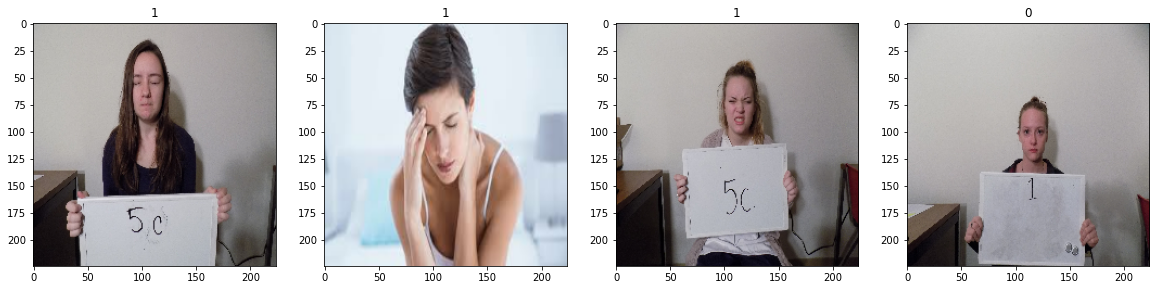

In [18]:
fig, ax = plt.subplots( ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

    # Quick check which label is for which picture. In this case 0 - happy, 1 - sad


2. Preprocess Data

2.1 Scale Data

In [19]:
data = data.map(lambda x,y: (x/255, y)) # Allows create transformation in pipline

In [20]:
scaled_iterator = data.as_numpy_iterator()

In [21]:
batch = scaled_iterator.next()

In [22]:
batch[0].min()

0.0

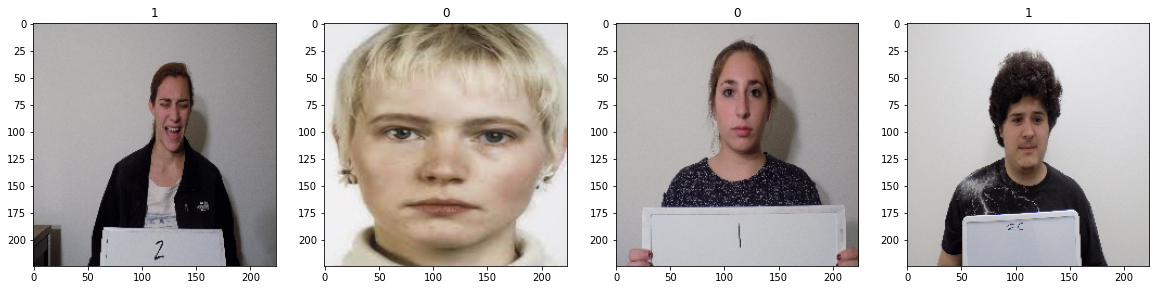

In [23]:
fig, ax = plt.subplots( ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data to Training and Testing 

In [24]:
len(data) # How many batches have we got. This example: 7 batches with 32 images each

23

In [25]:
# Split batches between training, validation and testing
# The sum of each has to equal the number of batches.
# In this case we got 7 batches: 4 for training, 2 for validation and 1 for testing.
train_size = int(len(data)*.7)-1
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

# train and val data is used in trianing process. Training data allow us to trian deep learning network, validation is for model checking
# test batch is to check the results of training our network -> used at the end

In [26]:
train_size

15

In [27]:
val_size

5

In [28]:
test_size

3

In [29]:
batches_size = train_size + val_size + test_size

In [30]:
batches_size

23

In [31]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# We allocate the batches of date to further training, validation and testing process. 
# .take() -> takes applied value of batches.
# .skip() -> skip applied value of batche.

# Important ! -> batches has to be shuffled before this process, and can not be shuffled after.
# It is, because we neeed to keep the order of taken batches to apply skip() function to work
# If we wanna shuffle data we has to back to: data = tf.keras.utils.image_dataset_from_directory('data'), and create new, shuffled batches

3. Deep model Creation

3.1 Build Deep Learning Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import keras
from keras.utils.vis_utils import plot_model
import graphviz
import pydot

In [33]:
VGG = keras.applications.VGG16(input_shape=(224,224,3), include_top = False, weights='imagenet')
VGG.trainable = False

In [34]:
model = keras.Sequential([
    VGG,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

In [35]:
# W have t ocompile our model. We use 'adam' optimizer (one of many)
model.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [36]:
model.summary() # Allow us to see how the model is converting the input data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,203,521
Trainable params: 6,488,833
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot_VGG16.png', show_shapes=True, show_layer_names=True)

3.2 Train

In [37]:
logdir = "logs"

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
# model.fit(): takes training date (dividie earlier in the code), epoches -> how many times we wnat to train our model 
# -> one epoch is runinng over entire training set of data
# the nwe pass our validation vlaues, so we can know how great performance has our model in real-time domain

Epoch 1/20
15/15 [==============================] - 34s 2s/step - loss: 0.9412 - accuracy: 0.6292 - val_loss: 0.4889 - val_accuracy: 0.7625
Epoch 2/20
15/15 [==============================] - 29s 2s/step - loss: 0.4168 - accuracy: 0.7917 - val_loss: 0.4303 - val_accuracy: 0.7750
Epoch 3/20
15/15 [==============================] - 31s 2s/step - loss: 0.3585 - accuracy: 0.8625 - val_loss: 0.2795 - val_accuracy: 0.8625
Epoch 4/20
15/15 [==============================] - 28s 2s/step - loss: 0.1479 - accuracy: 0.9542 - val_loss: 0.1344 - val_accuracy: 0.9625
Epoch 5/20
15/15 [==============================] - 26s 1s/step - loss: 0.0900 - accuracy: 0.9833 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 6/20
15/15 [==============================] - 26s 2s/step - loss: 0.0592 - accuracy: 0.9833 - val_loss: 0.0699 - val_accuracy: 0.9750
Epoch 7/20
15/15 [==============================] - 27s 2s/step - loss: 0.0702 - accuracy: 0.9792 - val_loss: 0.1129 - val_accuracy: 0.9625
Epoch 8/20
15/15 [==

3.3 Plot Performance

In [40]:
hist.history

{'loss': [0.9411745667457581,
  0.41675636172294617,
  0.358458936214447,
  0.14786124229431152,
  0.08998163789510727,
  0.0591895692050457,
  0.07022123038768768,
  0.05859029293060303,
  0.06833071261644363,
  0.04158977419137955,
  0.03171940892934799,
  0.014390210621058941,
  0.007985220290720463,
  0.004519743379205465,
  0.008569278754293919,
  0.0039865137077867985,
  0.0027217562310397625,
  0.003536219010129571,
  0.0026502676773816347,
  0.0007113919127732515],
 'accuracy': [0.6291666626930237,
  0.7916666865348816,
  0.862500011920929,
  0.9541666507720947,
  0.9833333492279053,
  0.9833333492279053,
  0.9791666865348816,
  0.9750000238418579,
  0.9666666388511658,
  0.987500011920929,
  0.9916666746139526,
  0.9958333373069763,
  1.0,
  1.0,
  0.9958333373069763,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.4888879358768463,
  0.43028759956359863,
  0.2794574797153473,
  0.13435454666614532,
  0.04883160442113876,
  0.06992761045694351,
  0.1128978282213211,
  0.08

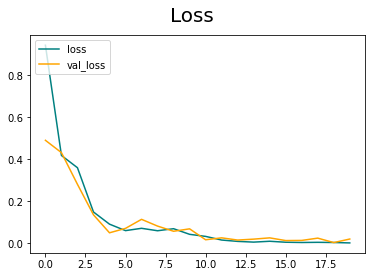

In [41]:
# Cause we saved information in hist variable, we cna now plot some interesting plots
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

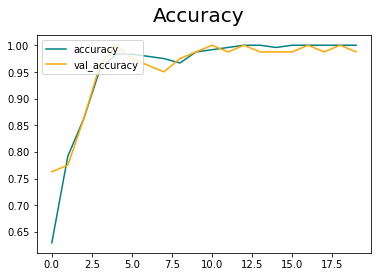

In [42]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

4. Evaluate Performance

4.1 Evaluate

In [43]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [44]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [45]:
for batch in test.as_numpy_iterator():
    X, y = batch
    ythat = model.predict(X)
    precision.update_state(y, ythat)
    recall.update_state(y, ythat)
    accuracy.update_state(y, ythat)
    

1/1 [==============================] - 2s 2s/step


In [46]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


4.2 Test

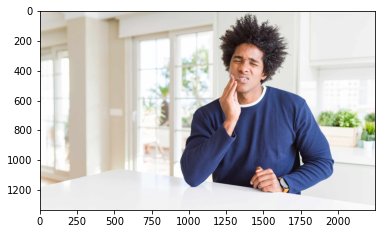

In [86]:
#img = cv2.imread('pain_test.JPG')
img = cv2.imread('test_Data/pain_test_v2.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

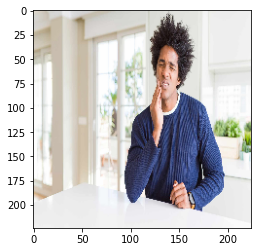

In [87]:
# We resized all batches of data to 256x256 size. The input data has to be the same size !!!
resize_img = tf.image.resize(img, (224,224))
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [88]:
yhat = model.predict(np.expand_dims(resize_img/255, 0)) 
# The model expect the batch of data not a single image, so we have to wrap data into batch (deeper into the list)

1/1 [==============================] - 0s 30ms/step


In [89]:
yhat
#In this case 0 - happy, 1 - sad

array([[0.9999784]], dtype=float32)

In [90]:
if yhat < 0.5:
    print('We are Normal Normal People, Yuhu :) !!!')
else:
    print("Hello Pain My Old Friend :( ")

Hello Pain My Old Friend :( 


5. Save model

In [91]:
from tensorflow.keras.models import load_model
import os
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [93]:
#model.save(os.path.join('models', 'pain_detection_model_VGG16.h5'))

6. Reuse the model

In [107]:
new_model = load_model(os.path.join('models', 'pain_detection_model_VGG16.h5'))

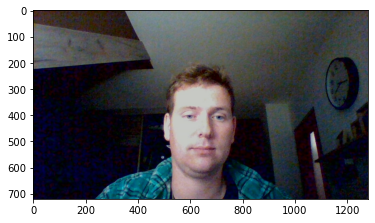

In [129]:
input_img = cv2.imread('test_Data/WIN_20220901_20_17_59_Pro.jpg')
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(input_img)
plt.show()

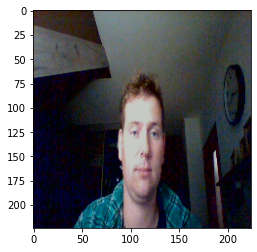

In [130]:
resized_img = tf.image.resize(input_img, (224,224))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [131]:
yhat_new = new_model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 31ms/step


In [132]:
yhat_new

array([[0.9177871]], dtype=float32)

Hello Pain My Old Friend :( 


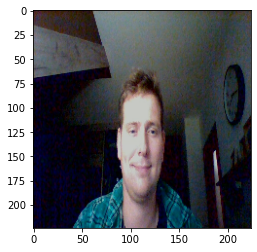

In [124]:
if yhat_new < 0.5:
    print('We are Normal Normal People, Yuhu :) !!!')
    plt.imshow(resized_img.numpy().astype(int))
else:
    print("Hello Pain My Old Friend :( ")
    plt.imshow(resized_img.numpy().astype(int))